# Installing EasyVVUQ

This example is based on https://github.com/vecma-project/VECMA-tutorials/blob/master/EasyVVUQ/Cooling_Cup/EasyVVUQ_Cooling_Cup.ipynb and was updated based on the latest EasyVVUQ interface available at https://github.com/UCL-CCS/EasyVVUQ/blob/dev/tutorials/easyvvuq_pce_tutorial.py

Before we do anything else we need to install EasyVVUQ for use in this notebook. Note that `easyvvuq v1.0` is assumed.

In [1]:
!conda list

# packages in environment at /Users/Juraj/anaconda3/envs/easy_vvuq:
#
# Name                    Version                   Build  Channel
anyio                     3.3.0            py39h6e9494a_0    conda-forge
appnope                   0.1.2            py39h6e9494a_1    conda-forge
argon2-cffi               20.1.0           py39h89e85a6_2    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
autopep8                  1.5.7                    pypi_0    pypi
babel                     2.9.1              pyh44b312d_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
bleach                    4.1.0              pyhd8ed1ab_0    conda-forge
bokeh                     2.3.3                    pypi_0    py

$$
\def\CC{\bf C}
\def\QQ{\bf Q}
\def\RR{\bf R}
\def\ZZ{\bf Z}
\def\NN{\bf N}
$$
# A Cooling Coffee Cup with Polynomial Chaos Expansion

In this tutorial we will perform a Polynomial Chaos Expansion for a
model of a cooling coffee cup. The model uses Newton's law of cooling to
evolve the temperature, $T$, over time ($t$) in an environment at
$T_{env}$ :

$$\frac{dT(t)}{dt} = -\kappa (T(t) -T_{env})$$

The constant $\kappa$ characterizes the rate at which the coffee cup
transfers heat to the environment. In this example we will analyze this
model using the polynomial chaos expansion (PCE) UQ algorithm. We will
use a constant initial temperature $T_0 = 95 ^\circ\text{C}$, and vary
$\kappa$ and $T_{env}$ using a uniform distribution in the ranges
$0.025-0.075$ and $15-25$ respectively.

The model was implemented as a Python script. But your code does not have to be written in Python and is indeed not expected to be. 

## EasyVVUQ Script Overview

We illustrate the intended workflow using the following basic example
script, a python implementation of the cooling coffee cup model used in
the textit{uncertainpy} documentation (code for which is in the
tests/cooling/ subdirectory of the EasyVVUQ distribution directory). The
code takes a small key/value pair input and outputs a comma separated
value CSV) file.

The input files for this tutorial are the *cooling\_model* application
(`cooling_model.py <tutorial_files/cooling_model.py>`), an input
template (`cooling.template <tutorial_files/cooling.template>`) and the
EasyVVUQ workflow script
(`easyvvuq_pce_tutorial.py <tutorial_files/easyvvuq_pce_tutorial.py>`).

## Set-up

For this example we import both easyvvuq and chaospy (for the
distributions). EasyVVUQ will be referred to as 'uq' in the code. :

In [6]:
import easyvvuq as uq
import chaospy as cp
import os
from shutil import rmtree

## Create a new Campaign

We start by creating an
EasyVVUQ Campaign. Here we call it 'coffee\_pce'. :

In [8]:
work_dir = "/Users/Juraj/Documents/DXT/VECMA-tutorials-fork/EasyVVUQ/Cooling_Cup/"
campaign_work_dir = os.path.join(work_dir, "easyvvuq_tutorial")
# clear the target campaign dir
if os.path.exists(campaign_work_dir):
    rmtree(campaign_work_dir)
os.makedirs(campaign_work_dir)

In [9]:
db_location = "sqlite:///" + campaign_work_dir + "/campaign.db"
my_campaign = uq.Campaign(name='coffee_pce', db_location=db_location, work_dir=campaign_work_dir)
print(my_campaign)

db_location = sqlite:////Users/Juraj/Documents/DXT/VECMA-tutorials-fork/EasyVVUQ/Cooling_Cup/easyvvuq_tutorial/campaign.db
active_sampler_id = None
campaign_name = coffee_pce
campaign_dir = /Users/Juraj/Documents/DXT/VECMA-tutorials-fork/EasyVVUQ/Cooling_Cup/easyvvuq_tutorial/coffee_pceph4gviyk
campaign_id = 1



## Parameter space definition

The parameter space is defined using a dictionary. Each entry in the
dictionary follows the format:

`"parameter_name": {"type" : "<value>", "min": <value>, "max": <value>, "default": <value>}`

With a defined type, minimum and maximum value and default. If the
parameter is not selected to vary in the Sampler (see below) then the
default value is used for every run. In this example, our full parameter
space looks like the following: :

In [10]:
params = {
    "temp_init": {"type": "float", "min": 0.0, "max": 100.0, "default": 95.0},
    "kappa": {"type": "float", "min": 0.0, "max": 0.1, "default": 0.025},
    "t_env": {"type": "float", "min": 0.0, "max": 40.0, "default": 15.0},
    "out_file": {"type": "string", "default": "output.csv"}
}

## App Creation

In this example the GenericEncoder and SimpleCSV, both included in the
core EasyVVUQ library, were used as the encoder/decoder pair for this
application. :

In [11]:
from pathlib import Path

encoder = uq.encoders.GenericEncoder(
    template_fname="cooling.template",
    delimiter="$",
    target_filename="cooling_in.json"
)

decoder = uq.decoders.SimpleCSV(
    target_filename="output.csv",
    output_columns=["te"]
)

In [12]:
execute = uq.actions.ExecuteLocal(
    "python3 {}/cooling_model.py cooling_in.json".format(work_dir)
)

In [13]:
actions = uq.actions.Actions(
    uq.actions.CreateRunDirectory(root=campaign_work_dir, flatten=True),
    uq.actions.Encode(encoder),
    execute,
    uq.actions.Decode(decoder)
)

GenericEncoder performs simple text substitution into a supplied
template, using a specified delimiter to identify where parameters
should be placed. The template is shown below (\$ is used as the
delimiter). The template substitution approach is likely to suit most
simple applications but in practice many large applications have more
complex requirements, for example the multiple input files or the
creation of a directory hierarchy. In such cases, users may write their
own encoders by extending the BaseEncoder class. :

In [ ]:
{
   "T0":"$temp_init",
   "kappa":"$kappa",
   "t_env":"$t_env",
   "out_file":"$out_file"
}

As can be inferred from its name SimpleCSV reads CVS files produced by
the cooling model code. Again many applications output results in
different formats, potentially requiring bespoke Decoders. Having
created an encoder, decoder and parameter space definition for our
$cooling$ app, we can add it to our campaign. :

In [14]:
# Add the app (automatically set as current app)
my_campaign.add_app(
    name="cooling",
    params=params,
    actions=actions
)

## The Sampler

The user specified which parameters will vary and their corresponding
distributions. In this case the kappa and t\_env parameters are varied,
both according to a uniform distribution: :

In [15]:
vary = {
    "kappa": cp.Uniform(0.025, 0.075),
    "t_env": cp.Uniform(15, 25)
}

To perform a polynomial chaos expansion we will create a PCESampler,
informing it which parameters to vary, and what polynomial rder to use
for the PCE. :

In [16]:
my_sampler = uq.sampling.PCESampler(vary=vary, polynomial_order=3)

Finally we set the campaign to use this sampler. :

In [17]:
my_campaign.set_sampler(my_sampler)

Calling the campaign's draw\_samples() method will cause the specified
number of samples to be added as runs to the campaign database, awaiting
encoding and execution. If no arguments are passed to draw\_samples()
then all samples will be drawn, unless the sampler is not finite. In
this case PCESampler is finite (produces a finite number of samples) and
we elect to draw all of them at once: :

In [18]:
my_campaign.draw_samples()

[{'kappa': 0.028471592210148697,
  't_env': 15.694318442029738,
  'temp_init': 95.0,
  'out_file': 'output.csv'},
 {'kappa': 0.028471592210148697,
  't_env': 18.30009478207572,
  'temp_init': 95.0,
  'out_file': 'output.csv'},
 {'kappa': 0.028471592210148697,
  't_env': 21.699905217924275,
  'temp_init': 95.0,
  'out_file': 'output.csv'},
 {'kappa': 0.028471592210148697,
  't_env': 24.305681557970267,
  'temp_init': 95.0,
  'out_file': 'output.csv'},
 {'kappa': 0.0415004739103786,
  't_env': 15.694318442029738,
  'temp_init': 95.0,
  'out_file': 'output.csv'},
 {'kappa': 0.0415004739103786,
  't_env': 18.30009478207572,
  'temp_init': 95.0,
  'out_file': 'output.csv'},
 {'kappa': 0.0415004739103786,
  't_env': 21.699905217924275,
  'temp_init': 95.0,
  'out_file': 'output.csv'},
 {'kappa': 0.0415004739103786,
  't_env': 24.305681557970267,
  'temp_init': 95.0,
  'out_file': 'output.csv'},
 {'kappa': 0.05849952608962141,
  't_env': 15.694318442029738,
  'temp_init': 95.0,
  'out_file': 

## Execute Runs and Collation

my\_campaign.populate\_runs\_dir() will create a directory hierarchy
containing the encoded input files for every run that has not yet been
completed.

Calling my\_campaign.collate() at any stage causes the campaign to
aggregate decoded simulation output for all runs which have not yet been
collated. :

In [20]:
my_campaign.execute().collate()

## Analysis

This collated data is stored in the campaign database. An analysis
element, here PCEAnalysis, can then be applied to the campaign's
collation result. :

In [21]:
# Post-processing analysis
my_analysis = uq.analysis.PCEAnalysis(sampler=my_sampler, qoi_cols=["te"])
my_campaign.apply_analysis(my_analysis)

The output of the analysis can be next queried in order to get detailed statistics:

In [28]:
# Get Descriptive Statistics
results = my_campaign.get_last_analysis()
mean = results.describe("te", "mean")
std = results.describe("te", "var")
p10 = results.describe("te", "10%")
p90 = results.describe("te", "90%")

s1_kappa = results._get_sobols_first('te', 'kappa')
s1_t_env = results._get_sobols_first('te', 't_env')


#print(f'Mean:\n{mean}')
#print(f'Std:\n{std}')
#print(f'p10:\n{p10}')
#print(f'p90:\n{p90}')

## I want to see how the results might look:





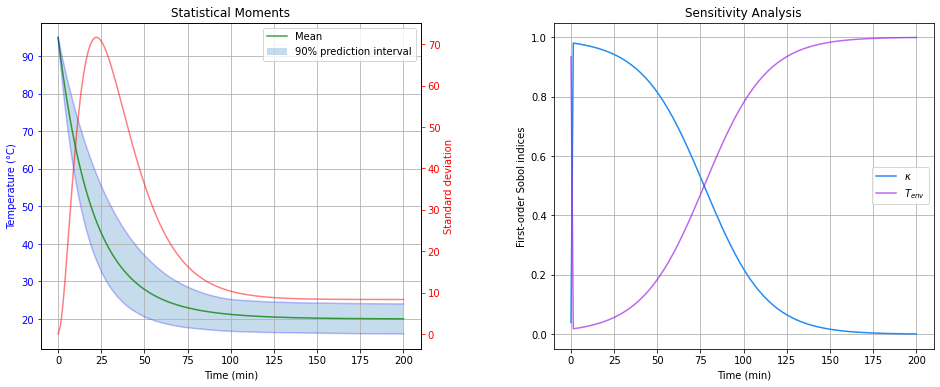

In [29]:
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(0, 200, 150)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax1.plot(t, mean, 'g-', alpha=0.75, label='Mean')
ax1.plot(t,  p10, 'b-', alpha=0.25)
ax1.plot(t,  p90, 'b-', alpha=0.25)
ax1.fill_between(
  t,
  p10,
  p90,
  alpha=0.25,
  label='90% prediction interval')
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Temperature (°C)', color='b')
ax1.tick_params('y', colors='b')
ax1.legend()

ax1t = ax1.twinx()
ax1t.plot(t, std, 'r-', alpha=0.5)
ax1t.set_ylabel('Standard deviation', color='r')
ax1t.tick_params('y', colors='r')

ax1.grid()
ax1.set_title('Statistical Moments')

ax2.plot(t, s1_kappa, '-', color ='#248BF2', label=r'$\kappa$')
ax2.plot(t, s1_t_env, '-', color ='#9402E8', alpha=0.6,label=r'$T_{env}$')

ax2.set_xlabel('Time (min)')
ax2.set_ylabel('First-order Sobol indices')
ax2.set_title('Sensitivity Analysis')
ax2.grid()
ax2.legend()

plt.subplots_adjust(wspace=0.35)

plt.show()

These plots show the statistical moments (mean, variance, and 90% prediction interval) and the sensitivity analysis of the model to each parameter, expressed through the first-order Sobol indices.

<AxesSubplot:xlabel='Time', ylabel='First Order Sobol Index'>

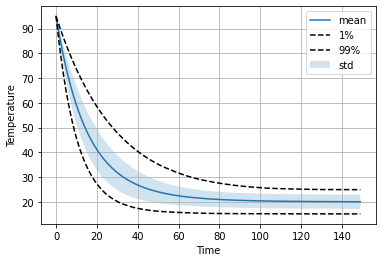

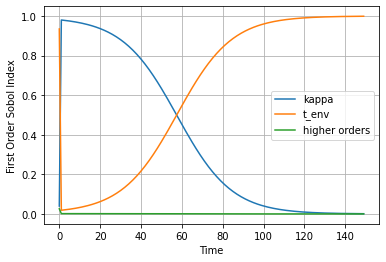

In [30]:
# Plots
t = np.linspace(0, 200, 150)
results.plot_moments(qoi="te", ylabel="Temperature", xlabel="Time", alpha=0.2)
results.plot_sobols_first(
    qoi="te", xlabel="Time",
    filename=os.path.join(campaign_work_dir, 'Te.png')
)